In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [7]:
def set_params(params, guess_flux, yerrs):
    """
    Creating a GaussianProcess object for a Matern32Term kernel. 

    Parameters
    ----------
    params : array_like
        Containing Matern32Term kernel parameters.
        _sigma, _rho = params 
    
    guess_flux : array_like
        Containing the physical (batman) model flux.
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    gp : GaussianProcess
        GaussianProcess object.

    """
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=guess_flux)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [8]:
TIC = 'TIC 420779000' #HAT-P-26b / TIC 420779000

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 420779000" SECTOR=50 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [9]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2665.276621666103,1.0008752e+00,1.6877042e-03,5.0983941e-03,1035228,1712.50806,1864.32177,6.1302373e+03,1.0319491e+01,1.5157616e+03,3.7660410e+00,7.1721631e+03,1.2093904e+01,0,———,———,———,———,1712.50806,1.3248915e-03,1864.32177,1.3110075e-03,-3.7879929e-02,1.0244901e-01
2665.2780106009227,9.9939626e-01,1.6885798e-03,5.0984407e-03,1035229,1712.51308,1864.32094,6.1227061e+03,1.0324845e+01,1.5224823e+03,3.7810454e+00,7.1615649e+03,1.2100179e+01,0,———,———,———,———,1712.51308,1.3261628e-03,1864.32094,1.3112831e-03,-3.2004643e-02,1.0131135e-01
2665.2793995357433,9.9927253e-01,1.6881203e-03,5.0984873e-03,1035230,1712.51125,1864.31516,6.1217334e+03,1.0322036e+01,1.5206570e+03,3.7757792e+00,7.1606782e+03,1.2096887e+01,0,———,———,———,———,1712.51125,1.3261768e-03,1864.31516,1.3103712e-03,-3.7128687e-02,9.5918149e-02
2665.2807884705635,1.0043720e+00,1.6912979e-03,5.0985338e-03,1035231,1712.50948,1864.32062,6.1531748e+03,1.0341465e+01,1.5216674e+03,3.7705452e+00,7.1972202e+03,1.2119657e+01,0,———,———,———,———,1712.50948,1.3216167e-03,1864.32062,1.3083346e-03,-3.4576565e-02,1.0225669e-01
2665.2821774058493,1.0007608e+00,1.6884294e-03,5.0985808e-03,1035232,1712.50742,1864.31755,6.1306606e+03,1.0323926e+01,1.5226661e+03,3.7688382e+00,7.1713428e+03,1.2099101e+01,0,———,———,———,———,1712.50742,1.3256199e-03,1864.31755,1.3087012e-03,-3.8559388e-02,1.0009597e-01
2665.2835663406704,9.9956930e-01,1.6884031e-03,5.0986274e-03,1035233,1712.51242,1864.31983,6.1226650e+03,1.0323764e+01,1.5179741e+03,3.7734630e+00,7.1628047e+03,1.2098912e+01,0,———,———,———,———,1712.51242,1.3269043e-03,1864.31983,1.3105640e-03,-3.4752984e-02,1.0057126e-01
2665.2849552754915,9.9820203e-01,1.6865281e-03,5.0986740e-03,1035234,1712.50889,1864.31878,6.1138428e+03,1.0312301e+01,1.5209933e+03,3.7675910e+00,7.1530068e+03,1.2085477e+01,0,———,———,———,———,1712.50889,1.3263194e-03,1864.31878,1.3127550e-03,-3.9159257e-02,1.0016379e-01
2665.2863442103117,9.9677658e-01,1.6860449e-03,5.0987205e-03,1035235,1712.51207,1864.32187,6.1045146e+03,1.0309346e+01,1.5252603e+03,3.7711377e+00,7.1427925e+03,1.2082014e+01,0,———,———,———,———,1712.51207,1.3281615e-03,1864.32187,1.3129751e-03,-3.5147920e-02,1.0174066e-01


In [10]:
#Removing an outlier

t = []
flux_data = []
yerrs = []

for time, flux, yerr in zip(lc.time.btjd, lc.flux, lc.flux_err):
    if flux <= 1.014: #Include fluxes below or equal to this value
        t.append(time)
        flux_data.append(flux)
        yerrs.append(yerr)
    else:
        print("removed: ", time, flux, yerr)

t = np.array(t)
flux_data = np.array(flux_data)
yerrs = np.array(yerrs)

removed:  2689.4826703255594 1.0152404308319092 0.0017015072517096996


In [11]:
filename = r"C:\Users\Student\OneDrive\MSci project\MSci2022_TESS\Transit_fitting\HAT_P_26b\gp_batman_model\free_ecc\HAT_P_26b_free_ecc_gp_batman_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [12]:
#batman model
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R*
model_ecc = np.percentile(flat_samples[:, 5], 50) #Eccentricity

#GP model
model_sigma = np.percentile(flat_samples[:, 6], 50)
model_rho = np.percentile(flat_samples[:, 7], 50)

prior_Rs = 0.8564404 #R_sun, Gaia DR2

model_params = batman.TransitParams()
model_params.t0 = model_T0
model_params.per = model_per
model_params.rp = model_Rp
model_params.a = model_a
model_params.inc = model_inc
model_params.ecc = model_ecc
model_params.w = 46.0 #Knutson et al. 2014
model_params.limb_dark = "quadratic"
model_params.u = [0.35092681757927346, 0.22991353177818383] #Estimated from WASP_39b_ldc.ipynb

m = batman.TransitModel(model_params, t) #Use TESS time series, t
batman_model = m.light_curve(model_params)

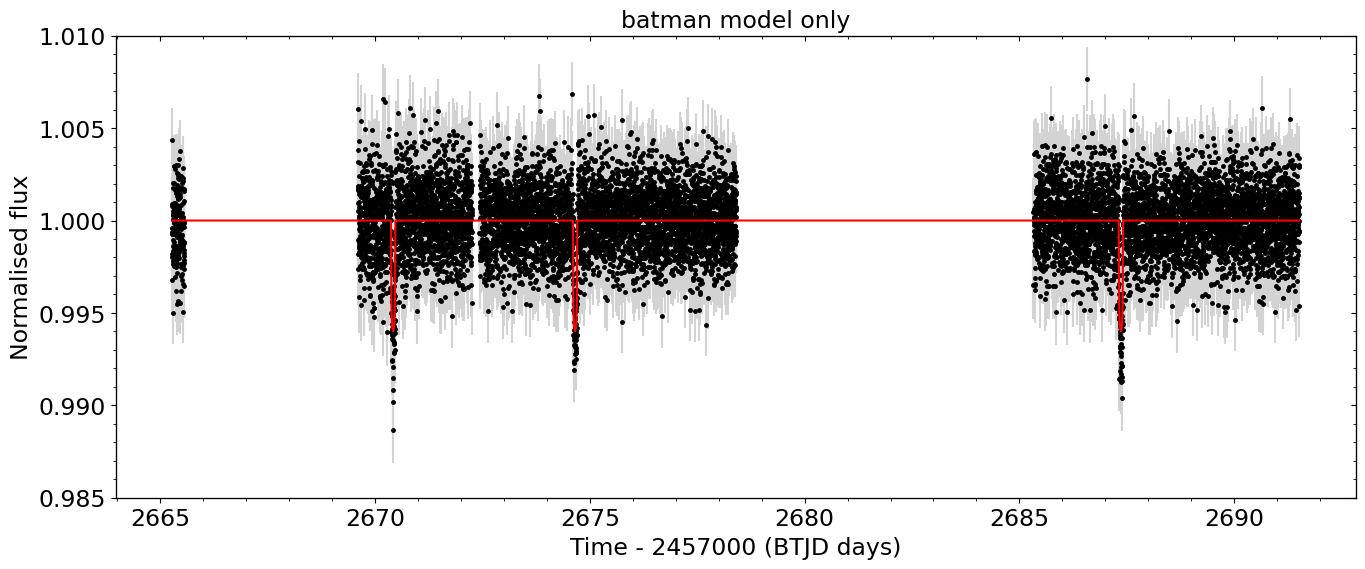

In [13]:
#batman
ylim = [0.985, 1.01]
fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t, batman_model, color='Red', zorder=10)


# ax.set_xlim([min(t) - 1, max(t) + 1])
ax.set_ylim(ylim)
ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)
ax.set_title("batman model only", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [14]:
"""
batman + gp-model
"""

filename = r"C:\Users\Student\OneDrive\MSci project\MSci2022_TESS\Transit_fitting\HAT_P_26b\gp_batman_model\free_ecc\HAT_P_26b_model_flux.p"

if os.path.exists(filename) == True:
    with open(filename, "rb") as f:
        t_none, gp_batman_model = pickle.load(f)
    f.close()

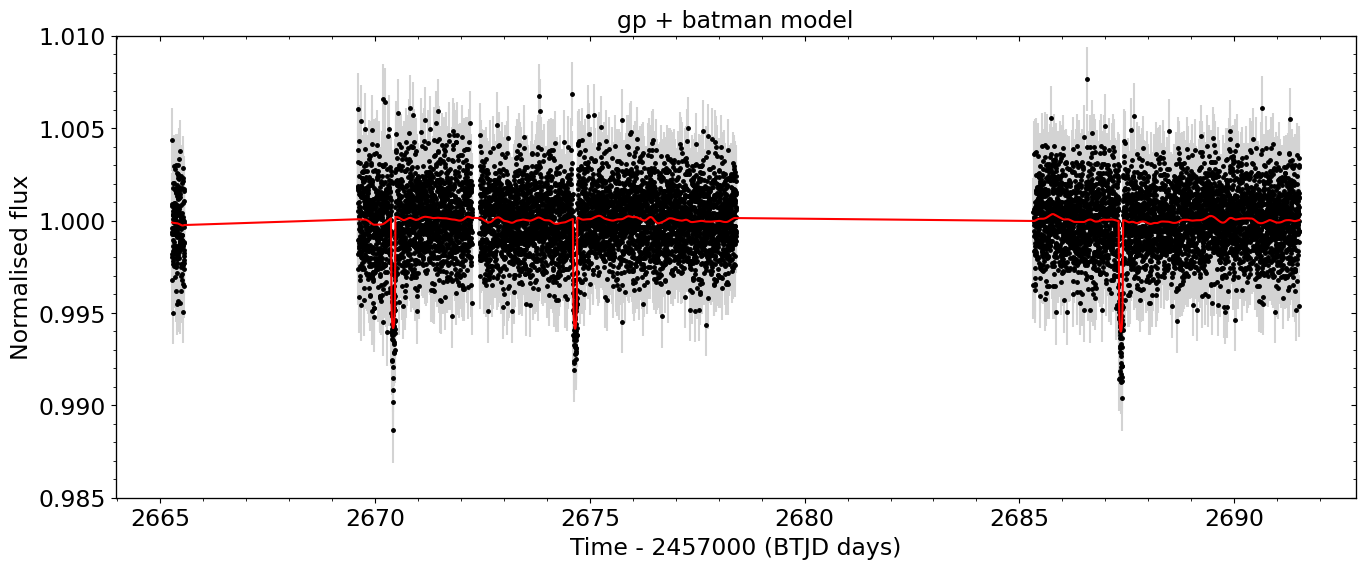

In [15]:
#batman + gp model
ylim = [0.985, 1.01]
fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t, gp_batman_model, color='Red', zorder=10)


# ax.set_xlim([min(t) - 1, max(t) + 1])
ax.set_ylim(ylim)
ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)
ax.set_title("gp + batman model", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [16]:
gp_model = gp_batman_model - batman_model

In [17]:
data_export = {"Time (BTJD)" : t , "Normalised flux" : flux_data, "batman model" : batman_model, "GP model" : gp_model}
df = pd.DataFrame(data_export)

df.to_csv("HAT_P_26b_data_model.csv", index=False)